# Uncertainties in modelling.
### Load libraries


In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import pandas as pd
import sympy as sp
%matplotlib inline

Our well established routines.

In [2]:
def plot_flow(ax,rhs,xrange=[-2.5,2.5],yrange=[-2.5,2.5],xnum=100,ynum=100,nullclines=False,args=None):
    # Set up u,v space
    u = np.linspace(xrange[0], xrange[1], xnum)
    v = np.linspace(yrange[0], yrange[1], ynum)
    uu, vv = np.meshgrid(u, v)

# Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = rhs(0,np.array([uu[i,j], vv[i,j]]),*args)


# Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel,color='grey')
#Nullclines
    if nullclines: 
        ax.contour(uu, vv, u_vel, [0],colors=('r'))
        ax.contour(uu, vv, v_vel, [0],colors=('b'))

    return ax

# A function that plots a path 
# def plot_solution(ax,rhs,y0,t_end,t_dim=2000,color='green',init_pt=True,linewidth=2.5):

#     t = np.linspace(0, t_end, t_dim)
#     X = sc.integrate.solve_ivp(rhs,t_span=[t[0],t[-1]],y0=y0,t_eval=t)
#     x,y=X.y
#     t=X.t
#     ax.plot(x,y, color=color,linewidth=linewidth)
#     if (init_pt):
#         ax=plot_point(ax,y0,color=color)
#     return ax

def get_solution(rhs, y0, t_end, t_dim=2000,args=None):
    t = np.linspace(0, t_end, t_dim)
    sol = sc.integrate.solve_ivp(rhs, t_span=[t[0], t[-1]], y0=y0, t_eval=t,args=args)
    return sol

def plot_solution(ax, rhs, y0, t_end, t_dim=2000, color='green', init_pt=True, linewidth=2.5, linestyle='-',args=None):
    sol = get_solution(rhs, y0, t_end, t_dim,args)
    x, y = sol.y
    ax.plot(x, y, color=color, linewidth=linewidth,linestyle=linestyle)
    if init_pt:
        ax = plot_point(ax, y0, color=color)
    return ax

def plot_point(ax, coord, color='black',markersize=20):
    """Add fixed points to plot."""
    x,y=coord
    ax.plot(x,y, '.', color='black', markerfacecolor=color, markersize=markersize)
    return ax


def jacobian(rhs, xy, eps=1e-8,args=None):
    """
    Compute the Jacobian matrix of a system of differential equations at a given point.
    Parameters:
    rhs (function): The right-hand side function of the differential equations. It should take two arguments: time (t) and state (xy).
    xy (array-like): The point (x, y) at which to evaluate the Jacobian.
    eps (float, optional): A small perturbation value for numerical differentiation. Default is 1e-8.
    Returns:
    numpy.ndarray: A 2x2 Jacobian matrix evaluated at the point (x, y).
    Note:
    This function uses finite differences to approximate the partial derivatives.

    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    
    f0 = np.array(rhs(0, xy,args))
    jac = np.zeros((2, 2))
    
    for i in range(2):
        dxy = np.zeros(2)
        dxy[i] = eps
        f1 = np.array(rhs(0, xy + dxy,args))
        jac[:, i] = (f1 - f0) / eps
    
    return jac

def eigenvalues_eigenvectors(jac):
    """
    Calculate the eigenvalues and eigenvectors of a given Jacobian matrix.
    Parameters:
    jac (numpy.ndarray): A square matrix representing the Jacobian matrix.
    Returns:
    tuple: A tuple containing two elements:
        - eigenvalues (numpy.ndarray): An array of eigenvalues.
        - eigenvectors (numpy.ndarray): An array of eigenvectors, where each column is an eigenvector corresponding to the eigenvalue at the same index.


    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    eigenvalues, eigenvectors = np.linalg.eig(jac)
    return eigenvalues, eigenvectors





def plot_jordan(ax,rhs,r0=[0,0],rr=1,num=25,vectors=True, color='blue',linewidth=1.5,linestyle='dashed',args=None):
    theta=np.linspace(0,2*np.pi, num)
    x=rr*np.cos(theta)+r0[0]
    y=rr*np.sin(theta)+r0[1]
    ax.plot(x,y,linewidth=linewidth, color=color)
    if vectors:
        U,V=rhs(0,[x,y],args)
        ax.quiver(x,y,U,V)

    return ax




def winding_number(rhs, r0, rr, num=1000,args=None):
    theta = np.linspace(0, 2 * np.pi, num)
    x = rr * np.cos(theta) + r0[0]
    y = rr * np.sin(theta) + r0[1]
    
    F,G=rhs(0,[x,y],args)
    angles = np.arctan2(G, F)
    integrated_angle = np.sum(np.diff(np.unwrap(angles)))
    
    return integrated_angle / (2 * np.pi)




## The damped pendulum

We will use the pendulum as the example problem. 

Remember that the non-linear damped pendulum is described by 
$$
\begin{array}{rcl}
\dot{x} &=& \ y \\
\dot{y} &=& - \omega \sin (x) - \varphi  y
\end{array}
$$
where $\omega=\sqrt{g/l}$ is the frequency and  $\varphi=b/m$ is a friction parameter. 



### Phase diagrams and analysis


#### SymPy Analysis of the Equilibrium Points

To analyze the equilibrium points of the pendulum system, we can use SymPy to find the points where the derivatives are zero.

The equilibrium points occur where both $\dot{x}$ and $\dot{y}$ are zero.



This will give us the equilibrium points of the system in terms of the parameters $\omega$ and $\varphi$.


In [4]:
from sympy import latex

# Define the symbols
x, y, omega, phi = sp.symbols('x y omega phi')

# Define the system of equations
eq1 = sp.Eq(y, 0)
eq2 = sp.Eq(-omega * sp.sin(x) - phi * y, 0)

# Solve the system of equations for equilibrium points
equilibrium_points = sp.solve((eq1, eq2), (x, y))
jac = sp.Matrix([[0, 1], [-omega * sp.cos(x), -phi]])


for point in equilibrium_points:
    # Substitute the equilibrium point into the Jacobian matrix
    jac_subs = jac.subs({x: point[0], y: point[1]})
    
    # Compute the eigenvalues and eigenvectors of the substituted Jacobian matrix
    eigenvalues_subs, eigenvectors_subs = jac_subs.eigenvals(), jac_subs.eigenvects()
    
    display(Markdown(f"**Equilibrium point: ${sp.latex(point)}$**"))
    #print(f"Jacobian matrix at equilibrium point:\n{jac_subs}")
    display(Markdown(f"Eigenvalues: ${sp.latex(eigenvalues_subs)}$"))
    #display(Markdown(f"Eigenvectors: ${sp.latex(eigenvectors_subs)}$\n"))
# Compute the Jacobian matrix




**Equilibrium point: $\left( 0, \  0\right)$**

Eigenvalues: $\left\{ - \frac{\phi}{2} - \frac{\sqrt{- 4 \omega + \phi^{2}}}{2} : 1, \  - \frac{\phi}{2} + \frac{\sqrt{- 4 \omega + \phi^{2}}}{2} : 1\right\}$

**Equilibrium point: $\left( \pi, \  0\right)$**

Eigenvalues: $\left\{ - \frac{\phi}{2} - \frac{\sqrt{4 \omega + \phi^{2}}}{2} : 1, \  - \frac{\phi}{2} + \frac{\sqrt{4 \omega + \phi^{2}}}{2} : 1\right\}$

### The phase diagram.

In [5]:
# Define the system of ODEs,
def rhs_pendulum(t, xy, omega, phi ): 
    x,y=xy
    dx = y
    dy = - omega * np.sin(x) - phi*y 
    return [dx, dy]


Eigenvectors [(-1.59916927512658, 1, [Matrix([
[ 0.530196879601142],
[-0.847874559626135]])]), (1.59916927512658, 1, [Matrix([
[0.589709874324419],
[ 0.94304591225837]])])]


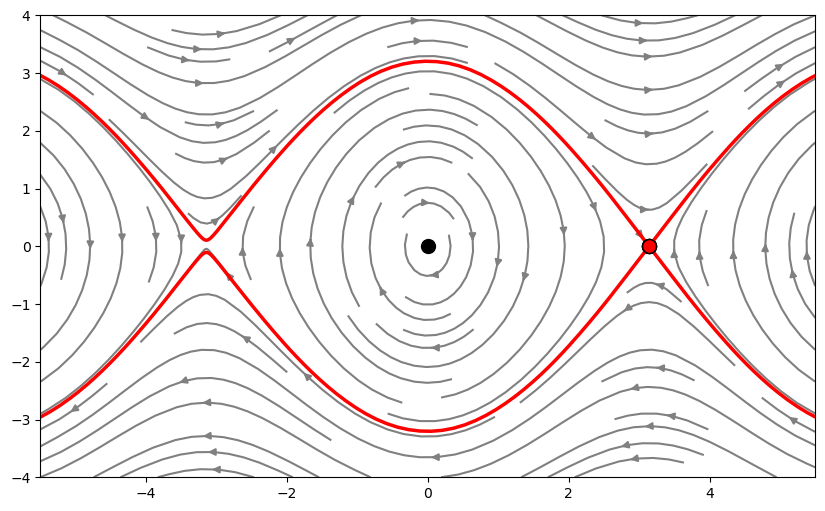

In [14]:
L= 1.5
omega = np.sqrt(9.81/L)
phi = 0  # 


jac_subs = jac.subs({x:sp.pi,sp.symbols('omega'): omega, sp.symbols('phi'): phi}).evalf()
eigenvals_num=jac_subs.eigenvals()
eigenvecs_num=jac_subs.eigenvects()
print(f'Eigenvectors {eigenvecs_num}')


# Define the right-hand side function for the pendulum

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
xrange=[-5.5, 5.5]
yrange=[-4, 4]
# Plot the flow
plot_flow(ax, rhs_pendulum, xrange=xrange,yrange=yrange, args=(omega, phi))

# Plot the equilibrium points
for point in equilibrium_points:
    ax = plot_point(ax, point)

# Plot the eigenvectors at the equilibrium points
for eigenvec in eigenvecs_num:
    val=np.sign(eigenvec[0])
    vec=1.e-6*eigenvec[2][0]
    for dir in [-1,1]:
        initial_condition = [np.pi+dir*vec[0],point[1]+dir*vec[1]]
        
        plot_solution(ax, rhs_pendulum, initial_condition, t_end=val*100, color='red', args=(omega, phi))
# Let's add some orbits starting close.        
        #initial_condition1 = [np.pi+dir*(vec[0]+1.e-2),point[1]+dir*vec[1]]
        #plot_solution(ax, rhs_pendulum, initial_condition1, t_end=val*100, color='green', args=(omega, phi),linestyle='dotted')


# Show the plot
ax.set_xlim(xrange)
ax.set_ylim(yrange)
plt.show()


<font color='green'> Play with the damping factor, </font> $\phi$ <font color='green'>what do you see?</font>

### Solutions in the time domain. 
Let's plot two solutions, starting close to each other, with time along the x-axis. 

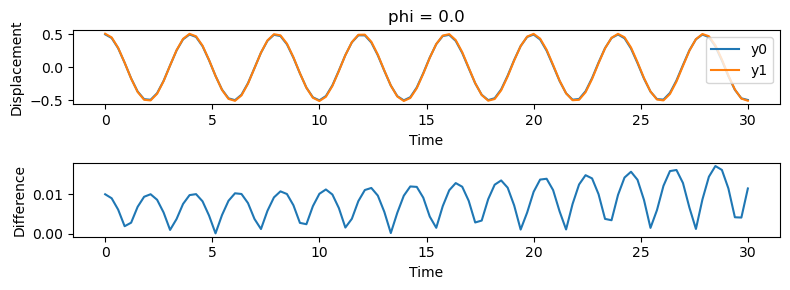

In [26]:

# Play with these values to see how the plots below change.

t_max=30 # Maximum time
t_num=100 # Number of time points
y0=[0.5,0] # Initial condition
eps=0.01 # Perturbation
L= 1.5
omega = np.sqrt(9.81/L)
phi = 0. #

# Create a time array
t_data = np.linspace(0, t_max, t_num)

y1=y0+np.array([eps,0]) # Perturb the initial condition

fig, axs = plt.subplots(2,1,figsize=(8, 3))

tmp0=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega,phi])
ax=axs[0]
ax.plot(t_data, tmp0.y[0], label='y0')
tmp1=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y1,t_eval=t_data,args=[omega,phi])
ax.plot(t_data, tmp1.y[0], label='y1')

ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
ax.legend()
ax.set_title(f'phi = {phi}')

ax=axs[1]
ax.plot(t_data, np.abs(tmp0.y[0]-tmp1.y[0]), label='|y0-y1|')
ax.set_xlabel('Time')
ax.set_ylabel('Difference')

plt.tight_layout()
plt.show()

<font color='green'> Play with the parameters in the cell above and see how the solutions and the difference changes. 
  </font>

Next, let's plot the solutions in the phase diagram.  

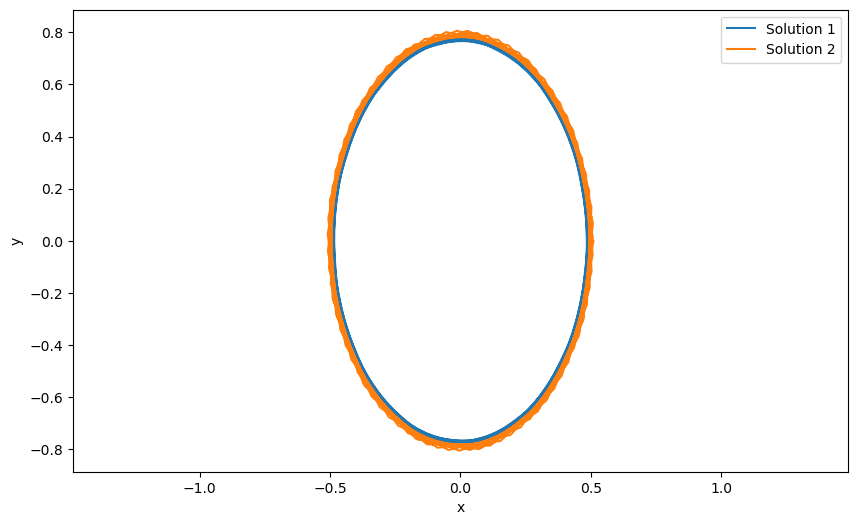

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the first solution
ax.plot(tmp0.y[0], tmp0.y[1], label='Solution 1')

# Plot the second solution
ax.plot(tmp1.y[0], tmp1.y[1], label='Solution 2')
ax.axis('equal')
ax.legend()
plt.show()

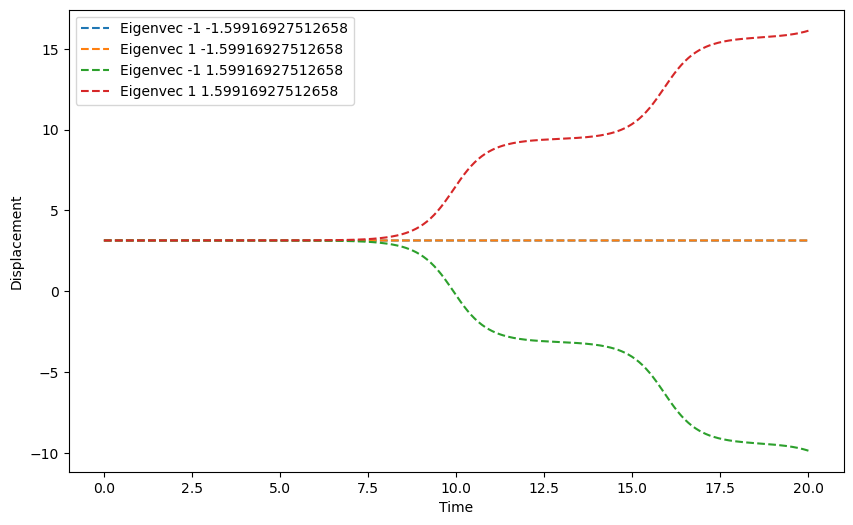

In [ ]:
t_num=400
t_max=20
t_data = np.linspace(0, t_max, t_num)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')

for eigenvec in eigenvecs_num:
    val=np.sign(eigenvec[0])
    vec=1.e-6*eigenvec[2][0]
    for dir in [-1,1]:
        initial_condition = [np.pi+dir*vec[0],point[1]+dir*vec[1]]
        tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=initial_condition,t_eval=t_data,args=[omega,phi])
        ax.plot(tmp.t, tmp.y[0], label=f'Eigenvec {dir} {eigenvec[0]}',linestyle='dashed')
ax.legend()
plt.show()

<font color='green'> Increase the time of integration. </font>

## Uncertainties in length or initial conditions

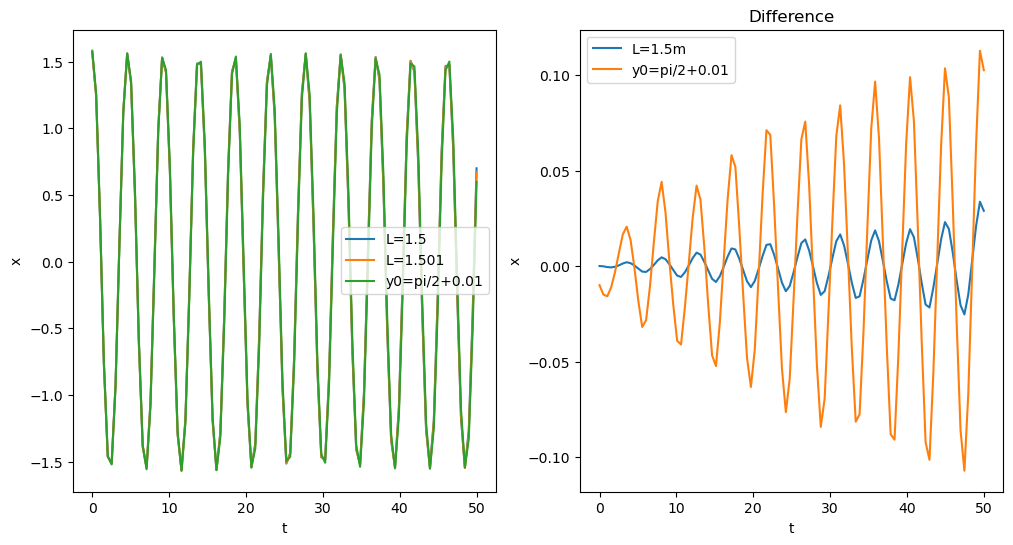

In [ ]:
L= 1.5
L_perturb=0.01
omega= np.sqrt(9.81/L)
L_perturb=0.01
L1=L*L_perturb
omega1= np.sqrt(9.81/L1)
phi = 0 # 
t_num=100
t_data = np.linspace(0, 50, t_num)
y0=[np.pi/2,0]
y1=[np.pi/2+0.01,0.01]
tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega,phi])
tmp1=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega1,phi])
tmp2=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y1,t_eval=t_data,args=[omega,phi])
data=tmp.y[0] #

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(tmp.t, tmp.y[0], label=f'L={L}')
ax[0].plot(tmp1.t, tmp1.y[0], label=f'L={L1:.3f}')
ax[0].plot(tmp2.t, tmp2.y[0], label='y0=pi/2+0.01')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].legend()

ax[1].plot(tmp.t, tmp.y[0]-tmp1.y[0], label=f'L=1.5m')
ax[1].plot(tmp1.t, tmp.y[0]-tmp2.y[0], label='y0=pi/2+0.01')
ax[1].set_title('Difference')
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')
ax[1].legend()
plt.show()

## Parameter estimation

Let's say we're measuring a pendulum. How do we determine the friction parameter?

Do the following:
1. Create synthetic data and add noise. 
2. Define an objective function
3. Use scipy.optimize.minimum to estimate the parameters. 

In [113]:
L= 1.
omega= np.sqrt(9.81/L)
phi = 0 # 
t_num=150
t_data = np.linspace(0, 50, t_num)
y0=[np.pi/2,0]

tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_data[-1]),y0=y0,t_eval=t_data,args=[omega,phi])

# Add random noise to the data
data=tmp.y[0] #*np.random.uniform(0.8,1.2)

noise_level = 0.02
observations = data * np.random.normal(1, noise_level, size=data.shape)


Let's have a look at the results

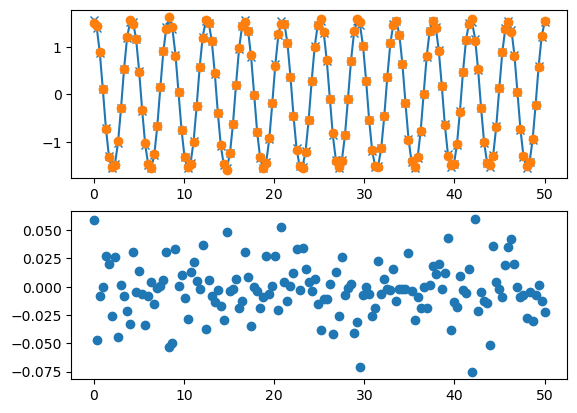

In [114]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(t_data,data,'-x',t_data,observations,'o')
axs[1].plot(t_data,data-observations,'o');

### The objective function

So now we have a set of observations, with noise. Lets estimate the parameters based on this. 

First we need an objective function.


In [115]:

def objective(params,t,y):
    omega, phi= params
    t_end=t[-1]
    y0=[y[0],0]
    tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega,phi])
    
    return np.sum((y - tmp.y[0]) ** 2)/len(y)



In [116]:
# Lets check the objective function
omega_guess=1
phi_guess=phi
obj_tmp=objective([omega_guess,phi_guess],t_data,observations)
obj_tmp

np.float64(2.3504056953518115)

Lets call the scipy function minimize. 

In [117]:
# Ensure t_data and observations have the same length

omega_guess=1
phi_guess=phi
result = sc.optimize.minimize(objective, [omega_guess, phi_guess], args=(t_data, observations))

# Calculate the error estimates
omega_error = np.sqrt(result.hess_inv[0, 0])
phi_error = np.sqrt(result.hess_inv[1, 1])


omega_calc = result.x[0]
phi_calc = result.x[1]
print('Omega given:', omega)
print('Omega estimated:', omega_calc)
print('Omega error estimate:', omega_error)
print('Phi given:', phi)
print('Phi estimated:', phi_calc)

print('Phi error estimate:', phi_error)

Omega given: 3.132091952673165
Omega estimated: 3.0553642310989435
Omega error estimate: 0.33785563856105566
Phi given: 0
Phi estimated: -0.00031441133298581547
Phi error estimate: 0.01370418872204857



1. Try to increase the noise, how good are the estimates? 
2. Increase the number of observations, will the estimates be better? 
3. Can you make the length of the pendulum as the unknown parameter? 


<font color='green'> Can you plot the solutions with the given and estimated parameters? </font>

## Probability distributions in Python

There are many distributions and Python has many statistical libraries that can provide sampling from them. We will use the ones provided by scipy, see documentation on [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html) 



### The uniform distribution


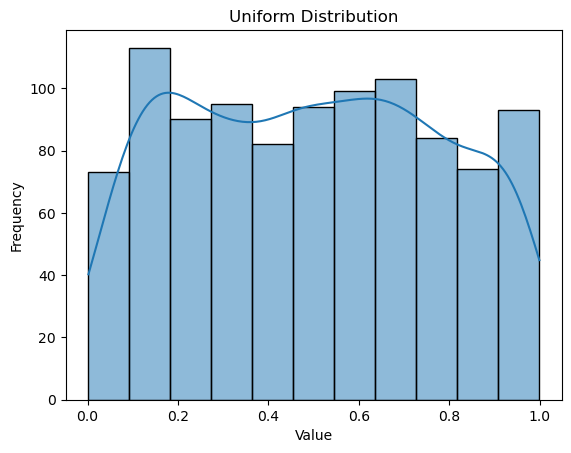

Mean value:  0.49610997530999973 Standard deviation:  0.2834842406945323


In [ ]:
n = 1000
start = 0
width = 1
x_uniform = sc.stats.uniform.rvs(size=n, loc = start, scale=width) # Generate random numbers
sns.histplot(x_uniform, kde=True) # Plot the histogram
print('Mean value: ',x_uniform.mean(),'Standard deviation: ',x_uniform.std())

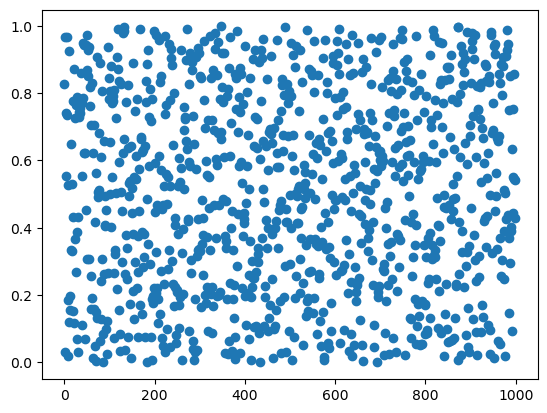

In [ ]:
plt.plot(x_uniform,'o')

Using the Seaborn routine


[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

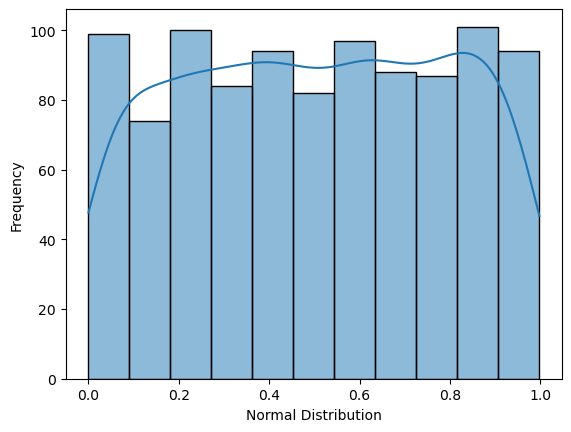

In [91]:
ax = sns.histplot(x_uniform,
                  kde=True,)
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

### The normal distribution

$$
 p(x)= \displaystyle\frac{1}{2\pi\sigma}e^{-\frac{(x-\mu)^2}{\sigma^2}}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation. 

In [29]:
n=10000
loc=2
scale = 4
x_norm=sc.stats.norm.rvs(size=n,loc=loc,scale=scale)
print('Mean: ', x_norm.mean(), ' Standard deviation: ', x_norm.std())

Mean:  1.9724119043188064  Standard deviation:  4.003039452211672


<Axes: ylabel='Count'>

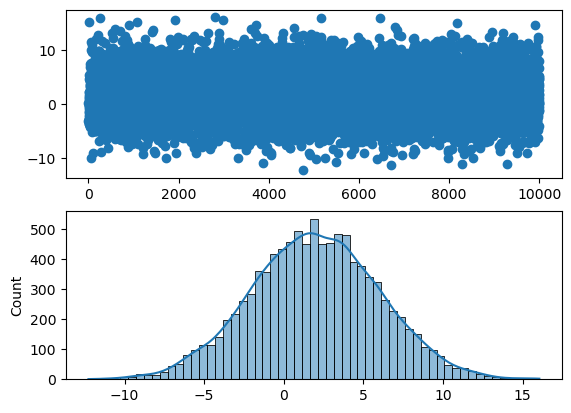

In [34]:
plt.subplot(2,1,1)
plt.plot(x_norm,'o')
plt.subplot(2,1,2)      
sns.histplot(x_norm, kde=True)

There are many other probability distributions. Check [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

## The pendulum (revisited)

Lets see how uncertainties in parameters influence on the model predictions. 

In [180]:

# Define the system of ODEs
def rhs_pendulum(t, xy, omega,phi=0 ): 
    x,y=xy
    dx = y
    dy = - omega * np.sin(x) - phi*y 
    return [dx, dy]


Lets assume that we have an uncertainty in our parameters.

In [38]:


# Set parameters
length_mean = 1.5
length_std = 0.1
g=9.18


#Draw and calculate frequency
l_num=10

l_norm=np.random.normal(loc=length_mean,scale=length_std, size=l_num)
l_unif=np.random.uniform(length_mean-2*length_std,length_mean+2*length_std,l_num)
omega_norm=np.sqrt(g/l_norm)
omega_unif=np.sqrt(g/l_unif)

#Create the time vector
t_end=40.
t_num=410
t = np.linspace(0, t_end, t_num)

# Set initial conditions
y0=[1,0]
x_norm=np.zeros((l_num,t_num))
y_norm=np.zeros((l_num,t_num))

x_unif=np.zeros((l_num,t_num))
y_unif=np.zeros((l_num,t_num))

for ii in np.arange(len(omega_norm)):
    tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega_norm[ii],phi])
    x_norm[ii,:]=tmp.y[0]
    y_norm[ii,:]=tmp.y[1]
    
for ii in np.arange(len(omega_unif)):
    tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega_unif[ii],phi])
    x_unif[ii,:]=tmp.y[0]
    y_unif[ii,:]=tmp.y[1]



    



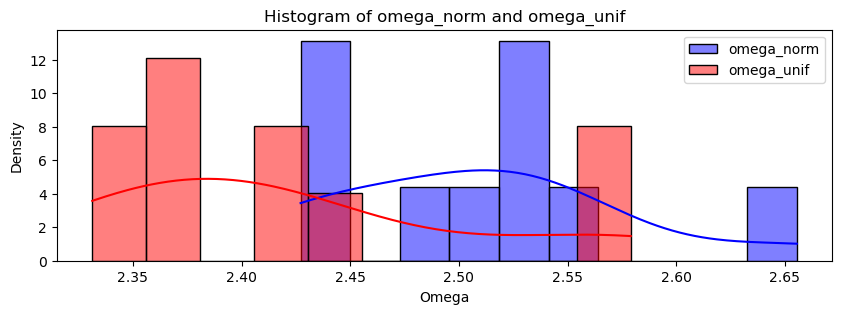

In [42]:
plt.figure(figsize=(10, 3))

# Plot histogram for omega_norm
sns.histplot(omega_norm, kde=True, color='blue', label='omega_norm', stat='density', bins=10)

# Plot histogram for omega_unif
sns.histplot(omega_unif, kde=True, color='red', label='omega_unif', stat='density', bins=10)

plt.xlabel('Omega')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of omega_norm and omega_unif')
plt.show()

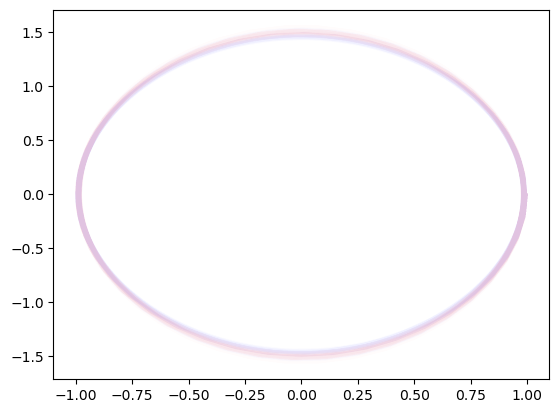

In [40]:
plt.plot(x_unif.T,y_unif.T,color='blue',alpha=0.01)
plt.plot(x_norm.T,y_norm.T,color='red',alpha=0.01)
plt.show()

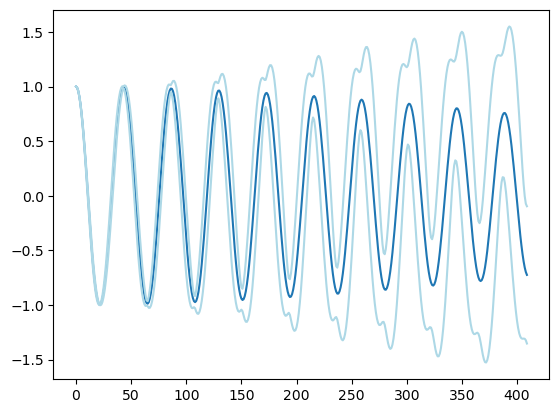

In [43]:
x=x_norm
plt.plot(x.mean(axis=0))
plt.plot(x.mean(axis=0)+2*x.std(axis=0),color='lightblue')
plt.plot(x.mean(axis=0)-2*x.std(axis=0),color='lightblue')
plt.show()

1. Can you make a loop that see how the mean and standard deviation estimate changes with the number of samples. 
2. See how this changes when you increase the uncertainties. 
3. Can you involve the friction term?

Here is a go at no 1. 

Create first a function that run the ensemble. 

Since we are only interested in the mean value and the standard deviation, $\sigma$, and to save memory we're using the following. 
$$
\begin{array}{rl}
 \sigma^2 =& \frac{1}{n}\sum_i ({\overline{x}-x_i})^2=  \frac{1}{n}\sum_i (\overline{x}^2-2\overline{x} x_i + x_i^2)\\ 
 & \\
= & \frac{1}{n}\sum_i \overline{x}^2-2\overline{x}\frac{1}{n}\sum_i x_i + \frac{1}{n}\sum_ix_i^2\\
& \\
= & \overline{x_i^2}-\overline{x}^2
\end{array}
$$



In [44]:

def run_ensemble(l_num=1000,length_mean = 1.0, length_std = 0.1, t_end=40., y0=[1,0],t_num=410, g=9.18,dist=0):
# A function that runs the ensembles for the pendulum
# Input: l_num, the number of samples in the ensemble
#       length_mean, the mean length of the pendulum
#       length_std, standard deviation of the length of the pendulum
#       g, is the gravitational constant
#       dist, the distribution function to use
# Output: t time when we do the statistics. 
#         x_mean, the mean values
#         Standard deviations.             
    if (dist == 0):
        l=np.random.normal(loc=length_mean,scale=length_std, size=l_num)
    elif(dist == 1):
        l=np.random.uniform(length_mean-2*length_std,length_mean+2*length_std,l_num)
    else:
        print('Not implemented yet, distr:', dist)
    

    omega=np.sqrt(g/l)


#Create the time vector, this should be an input. 
    
    t = np.linspace(0, t_end, t_num)



# Store the results. 
    x=t*0
    x2=t*0

    
# Here we loop through the samples. 

    for ii in np.arange(len(omega)):
        tmp=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=[omega[ii],phi])
        #Sum the x and the x squared. 
        x=x+tmp.y[0]
        x2=x2+tmp.y[0]**2

# and do the statistics
    x=x/l_num
    x2=np.sqrt((x2/l_num)-x**2)
    return [t,x,x2]
    

In [45]:
# Create an array of samples to run
l_nums=np.array([10,50,100,200, 300, 400, 500,800,1000,1500,2000,3000, 3500, 4000, 4500, 5000])
l_nums=np.array([2,5,10,50,100,150,500])
# Create arrays. 
t_num=400
# Set initial conditions, could also be an input. 
y0=[1,0]

x_mean=np.zeros((len(l_nums),t_num))
x_std=np.zeros((len(l_nums),t_num))

# Calculate a solution with the mean length
length_mean = 1.0
length_std = 0.2

g=9.81
t_end=15
t = np.linspace(0, t_end, t_num)
omega=np.sqrt(g/length_mean)
sol=sc.integrate.solve_ivp(rhs_pendulum,t_span=(0.,t_end),y0=y0,t_eval=t,args=(omega,phi))

for jj in np.arange(len(l_nums)): 
    tmp_t,tmp_mean,tmp_std=run_ensemble(l_num=l_nums[jj],length_mean = length_mean, length_std = 0.1,t_num=t_num,t_end=t_end, g=9.18,dist=0)
    x_mean[jj,:]=tmp_mean
    x_std[jj,:]=tmp_std
    


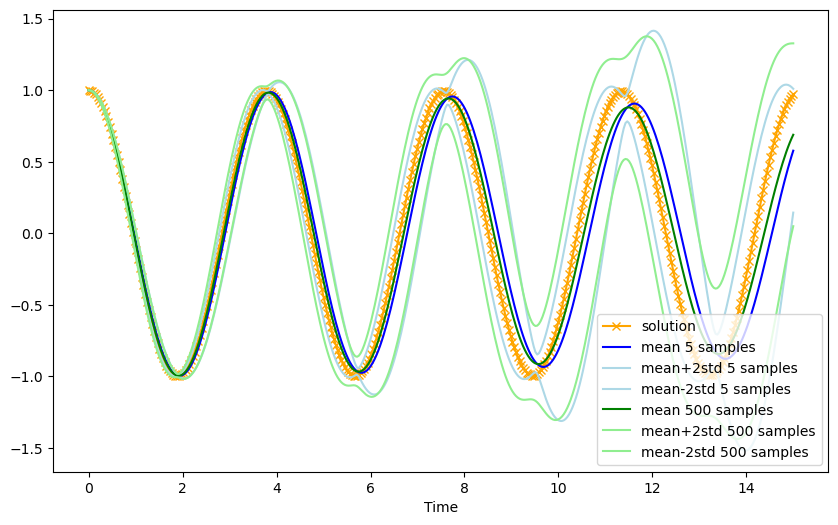

In [46]:
ii=1
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sol.t,sol.y[0],'x-',color='orange',label='solution')
ax.plot(sol.t,x_mean[ii,:],'-',color='blue',label=f'mean {l_nums[ii]} samples')
ax.plot(sol.t,x_mean[ii,:]+2*x_std[ii,:],'-',color='lightblue',label=f'mean+2std {l_nums[ii]} samples')
ax.plot(sol.t,x_mean[ii,:]-2*x_std[ii,:],'-',color='lightblue',label=f'mean-2std {l_nums[ii]} samples')

ii=-1
ax.plot(sol.t,x_mean[ii,:],'-',color='green',label=f'mean {l_nums[ii]} samples')
ax.plot(sol.t,x_mean[ii,:]+2*x_std[ii,:],'-',color='lightgreen',label=f'mean+2std {l_nums[ii]} samples')
ax.plot(sol.t,x_mean[ii,:]-2*x_std[ii,:],'-',color='lightgreen',label=f'mean-2std {l_nums[ii]} samples')

ax.legend()
ax.set_xlabel('Time');

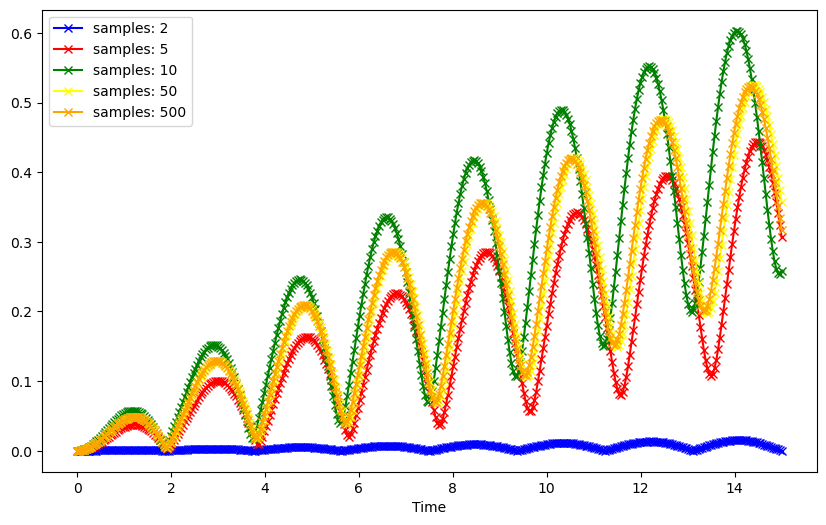

In [179]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sol.t,x_std[0,:],'x-',color='blue', label=f'samples: {l_nums[0]}')

ax.plot(sol.t,x_std[1,:],'x-',color='red', label=f'samples: {l_nums[1]}')
ax.plot(sol.t,x_std[2,:],'x-',color='green', label=f'samples: {l_nums[2]}')
ax.plot(sol.t,x_std[3,:],'x-',color='yellow',  label=f'samples: {l_nums[3]}')
ax.plot(sol.t,x_std[-1,:],'x-',color='orange', label=f'samples: {l_nums[-1]}')
ax.legend()
ax.set_xlabel('Time');

## Libraries to look into:
- Pandas [https://pandas.pydata.org/docs/index.html](https://pandas.pydata.org/docs/index.html)
- Seaborn [https://seaborn.pydata.org](https://seaborn.pydata.org) 
